<a href="https://colab.research.google.com/github/Chandu-9-9/FUTURE_ML_02/blob/main/Customer_Churn_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier


In [26]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
# =========================
# CLEANING (CORRECT & FUTURE-SAFE)
# =========================
df['Churn'] = (
    df['Churn']
    .replace({'Yes': 1, 'No': 0})
    .infer_objects(copy=False)
)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.fillna(df.median(numeric_only=True), inplace=True)


In [29]:
# =========================
# VERIFY
# =========================
print(df['Churn'].unique())          # expect [0 1]
print(df['TotalCharges'].dtype)      # expect float64
print(df.isnull().sum().sum())       # expect 0


[0 1]
float64
0


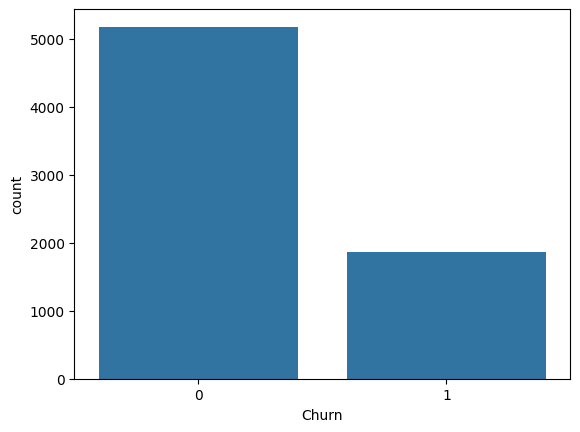

In [30]:
# =========================
# EDA (MINIMAL)
# =========================
sns.countplot(x='Churn', data=df)
plt.show()


In [31]:

df_encoded = pd.get_dummies(df, drop_first=True)


In [32]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [33]:

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.50      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [36]:

df['churn_probability'] = model.predict_proba(X)[:, 1]
df['churn_prediction'] = (df['churn_probability'] > 0.5).astype(int)

df.to_csv("churn_results.csv", index=False)


In [37]:
df['churn_probability'] = model.predict_proba(X)[:, 1]
df['churn_prediction'] = (df['churn_probability'] > 0.5).astype(int)

df[['churn_probability', 'churn_prediction']].head()


,churn_probability,churn_prediction
0,0.722950,1
1,0.014038,0
2,0.538620,1
3,0.007891,0
4,0.715419,1


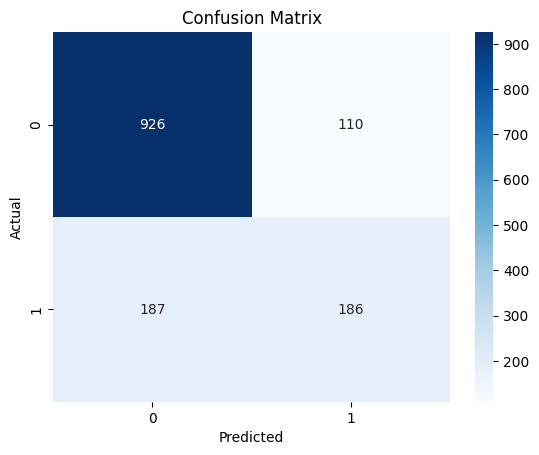

In [42]:


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [41]:

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.50      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



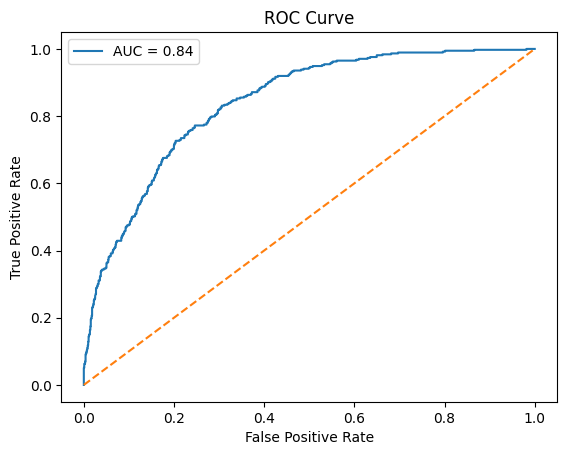

In [43]:


y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


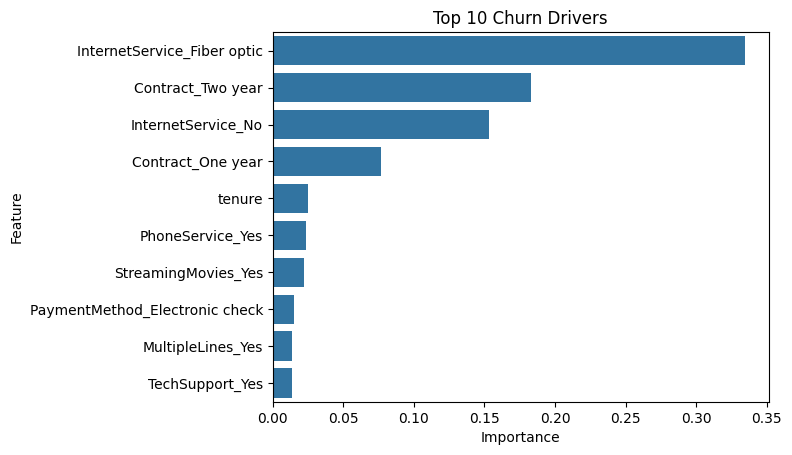

In [44]:
importances = model.feature_importances_
features = X.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Top 10 Churn Drivers")
plt.show()


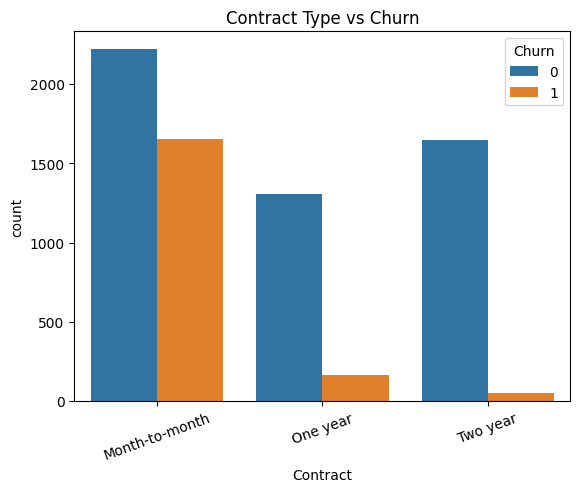

In [45]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.xticks(rotation=20)
plt.title("Contract Type vs Churn")
plt.show()


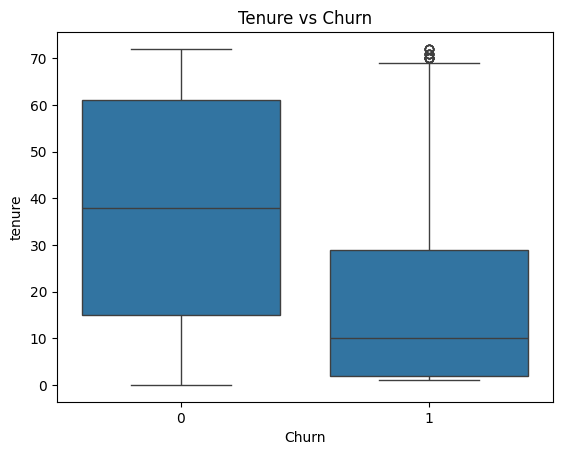

In [46]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()

